In [1]:
!gdown --id 1SXRluq9iwhAai0VGdpOfxO5YuRfD0Feo

Downloading...
From: https://drive.google.com/uc?id=1SXRluq9iwhAai0VGdpOfxO5YuRfD0Feo
To: /content/task1_dataset.zip
100% 3.54M/3.54M [00:00<00:00, 196MB/s]


In [2]:
!unzip -q -o task1_dataset.zip

In [3]:
import os
import glob
import itertools

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torchvision import transforms, models

torch.cuda.is_available()

True

In [4]:
action_to_id_map = {
    "left": 0,
    "palm": 1,
    "peace": 2,
    "right": 3,
}

id_to_action_map = {
    0: "left",
    1: "palm",
    2: "peace",
    3: "right",
}

def get_image_paths(data_dir="./dataset/images"):
    images = []
    actions = glob.glob(os.path.join(data_dir, "*"))
    for action in actions:
        label_name = os.path.basename(action)
        label_id = action_to_id_map[label_name]
        imgs = glob.glob(os.path.join(action, "*"))
        for img_name in imgs:
            images.append((img_name, label_id))
    train, test = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
    return train, test

train, test = get_image_paths()
train[0], test[0]

(('./dataset/images/left/left (25).jpg', 0),
 ('./dataset/images/left/left (18).jpg', 0))

In [5]:
def plot_distribution_of_data(df, title=""):
    activity, counts = np.unique(df.activity_name, return_counts=True)
    index = np.arange(len(activity))
    plt.figure(figsize=(12, 5))
    plt.bar(index, counts, align = 'center', alpha=0.5, color='lightblue')
    plt.suptitle(title, fontsize=16)
    plt.xticks(index, activity, rotation=90, fontsize=8)
    plt.xlim([-.5, 3.5])
    plt.ylabel('frequency', fontsize=10)
    for i, v in enumerate(counts):
        plt.text(i, v, str(v), color='grey', fontweight='bold')
    plt.show()

In [6]:
df = pd.DataFrame(train + test)
df.columns = ["img_path", "activity_name"]
df["activity_name"] = df["activity_name"].map(id_to_action_map)
df.head()

,img_path,activity_name
0,./dataset/images/left/left (25).jpg,left
1,./dataset/images/right/right (11).jpg,right
2,./dataset/images/left/left (8).jpg,left
3,./dataset/images/left/left (1).jpg,left
4,./dataset/images/left/left (2).jpg,left


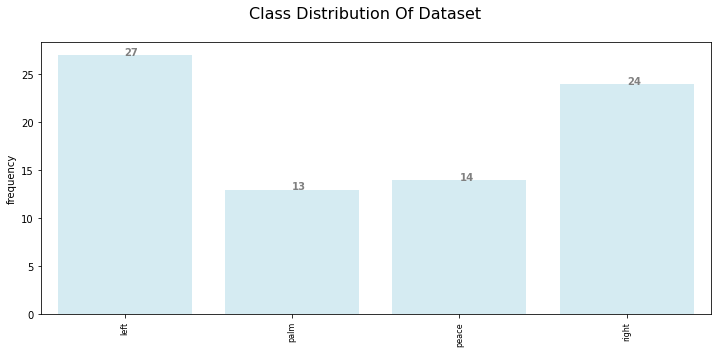

In [7]:
plot_distribution_of_data(df, title='Class Distribution Of Dataset')

In [8]:
def trainer(model, optimizer, criterion, train_loader, test_loader, model_name="cnn_model.pth", epochs=150):
    if torch.cuda.is_available():
      model.to("cuda")
    
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []
    best_accuracy = 0
    for epoch in range(epochs):
        train_loss = 0.0
        test_loss = 0.0
        total = 0
        correct = 0
        model.train()
        for step, (batch_image, batch_label) in enumerate(tqdm(train_loader)):
            if torch.cuda.is_available():
                batch_image, batch_label = batch_image.to("cuda"), batch_label.to("cuda")
            batch_output = model(batch_image)
            batch_loss = criterion(batch_output, batch_label)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            train_loss += batch_loss.item()

            # train accuracy
            _, train_predicted = torch.max(batch_output.data, 1)
            total += batch_label.size(0)
            correct += (train_predicted == batch_label).sum().item()

        train_acc = correct / total

        # ----------test----------
        total = 0
        correct = 0
        model.eval()
        with torch.no_grad():
          test_acc = 0.0
          for test_image, test_label in tqdm(test_loader):
              if torch.cuda.is_available():
                  test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
              test_output = model(test_image)
              batch_loss = criterion(test_output, test_label)
              test_loss += batch_loss.item()

              _, predicted = torch.max(test_output.data, 1)
              total += test_label.size(0)
              correct += (predicted == test_label).sum().item()
        test_acc = correct / total

        print('epoch={:d} train loss={:.6f} test loss={:.6f} train accuracy={:.3f} test accuracy={:.3f}'.format(
            epoch, train_loss / (step+1), test_loss / (step + 1), train_acc, test_acc)
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_losses.append(train_loss / (step+1))
        test_losses.append(test_loss / (step + 1))

        if test_acc > best_accuracy:
            torch.save(model.state_dict(), model_name)
            best_accuracy = test_acc
    return train_losses, test_losses, train_accs, test_accs

In [9]:
def tester(model, test_loader):
    if torch.cuda.is_available():
      model.to("cuda")
      
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
      for test_image, test_label in test_loader:
          if torch.cuda.is_available():
              test_image, test_label = test_image.to("cuda"), test_label.to("cuda")
          test_output = model(test_image)
          _, predicted = torch.max(test_output.data, 1)

          y_true.extend(list(test_label.cpu().numpy()))
          y_pred.extend(list(predicted.cpu().numpy()))
    return y_true, y_pred

In [10]:
def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1.1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

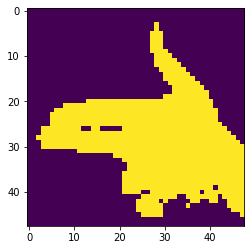

In [11]:
def processSkinImage(filePath, resize_HW=48):
    # step 1
    # read the image
    original = cv2.imread(filename=filePath)

    # step 2
    # resize the image to
    image_resized = cv2.resize(original, (resize_HW, resize_HW))

    # step 3
    # convert the image from rgb to YCbCr
    image_ycbcr = cv2.cvtColor(image_resized, cv2.COLOR_BGR2YCR_CB)

    # step 4
    # get the central color of the image
    # expected the hand to be in the central of the image
    Cb_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 1]
    Cr_center_color = image_ycbcr[int(resize_HW/2), int(resize_HW/2), 2]
    # set the range
    Cb_Difference = 15
    Cr_Difference = 10

    # step 5
    # detect skin pixels
    Cb = image_ycbcr[:, :, 1]
    Cr = image_ycbcr[:, :, 2]
    index = np.where((Cb >= Cb_center_color-Cb_Difference) & (Cb <= Cb_center_color+Cb_Difference)
                     & (Cr >= Cr_center_color-Cr_Difference) & (Cr <= Cr_center_color+Cr_Difference))

    # Mark detected pixels and output
    image_output = np.zeros((resize_HW, resize_HW))
    image_output[index] = 255

    # show image
    return image_output

filePath = "dataset/images/left/left (1).jpg"
plt.imshow(processSkinImage(filePath, resize_HW=48))
plt.show()

In [12]:
class MyDataset1(Dataset):
    def __init__(self, data, is_train):
        self.data = data
        self.is_train = is_train

        self.image_transform_train = transforms.Compose(
            [
                transforms.Resize(48), 
                transforms.CenterCrop(48),
                transforms.ToTensor(),
            ]
        )
        self.image_transform_test = transforms.Compose(
            [
                transforms.Resize(48),
                transforms.CenterCrop(48), 
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image = processSkinImage(image_name)
        image = Image.fromarray(image)
        if self.is_train:
            image_inp = self.image_transform_train(image)
        else:
            image_inp = self.image_transform_test(image)
        return image_inp, label

    def __len__(self):
        return len(self.data)

train, test = get_image_paths()
trainloader = DataLoader(MyDataset1(train, is_train=True), batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset1(test, is_train=False), batch_size=8, shuffle=True)

imgs, labels = next(iter(trainloader))
print(imgs.shape, labels.shape)
imgs, labels = next(iter(testloader))
print(imgs.shape, labels.shape)

torch.Size([8, 1, 48, 48]) torch.Size([8])
torch.Size([8, 1, 48, 48]) torch.Size([8])


In [13]:
class CNNModel1(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(800, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = CNNModel1(in_channels=1, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [14]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset1(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset1(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = CNNModel1(in_channels=1, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="CNNModel1.pth")

100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


epoch=0 train loss=1.363456 test loss=0.581511 train accuracy=0.315 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


epoch=1 train loss=1.327891 test loss=0.566212 train accuracy=0.370 test accuracy=0.458


100%|██████████| 3/3 [00:00<00:00,  4.57it/s]


epoch=2 train loss=1.297339 test loss=0.551257 train accuracy=0.426 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  4.30it/s]


epoch=3 train loss=1.263140 test loss=0.536806 train accuracy=0.463 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  7.27it/s]


epoch=4 train loss=1.235424 test loss=0.525119 train accuracy=0.574 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  6.52it/s]


epoch=5 train loss=1.200939 test loss=0.515587 train accuracy=0.648 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  5.80it/s]


epoch=6 train loss=1.172451 test loss=0.508449 train accuracy=0.648 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


epoch=7 train loss=1.147721 test loss=0.501872 train accuracy=0.667 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00,  7.35it/s]


epoch=8 train loss=1.118710 test loss=0.495967 train accuracy=0.685 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00, 12.94it/s]


epoch=9 train loss=1.102070 test loss=0.490594 train accuracy=0.722 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00, 13.47it/s]


epoch=10 train loss=1.073229 test loss=0.485516 train accuracy=0.759 test accuracy=0.583


100%|██████████| 3/3 [00:00<00:00, 13.64it/s]


epoch=11 train loss=1.054829 test loss=0.480705 train accuracy=0.815 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 13.55it/s]


epoch=12 train loss=1.045893 test loss=0.475944 train accuracy=0.889 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 13.15it/s]


epoch=13 train loss=1.021877 test loss=0.471621 train accuracy=0.889 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 12.66it/s]


epoch=14 train loss=1.003375 test loss=0.467350 train accuracy=0.889 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


epoch=15 train loss=0.980901 test loss=0.463151 train accuracy=0.944 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.83it/s]


epoch=16 train loss=0.966220 test loss=0.459060 train accuracy=0.944 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.18it/s]


epoch=17 train loss=0.959633 test loss=0.455229 train accuracy=0.944 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 12.51it/s]


epoch=18 train loss=0.939354 test loss=0.452006 train accuracy=0.963 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 12.92it/s]


epoch=19 train loss=0.930047 test loss=0.448746 train accuracy=0.963 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.48it/s]


epoch=20 train loss=0.917141 test loss=0.445648 train accuracy=0.963 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.45it/s]


epoch=21 train loss=0.912512 test loss=0.442674 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.66it/s]


epoch=22 train loss=0.896659 test loss=0.440118 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.15it/s]


epoch=23 train loss=0.889024 test loss=0.437370 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.26it/s]


epoch=24 train loss=0.881465 test loss=0.435286 train accuracy=0.963 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.12it/s]


epoch=25 train loss=0.878568 test loss=0.432940 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.04it/s]


epoch=26 train loss=0.871994 test loss=0.430816 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.61it/s]


epoch=27 train loss=0.859576 test loss=0.429041 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.45it/s]


epoch=28 train loss=0.855299 test loss=0.427582 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.70it/s]


epoch=29 train loss=0.852431 test loss=0.426032 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.55it/s]


epoch=30 train loss=0.848997 test loss=0.424539 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 12.59it/s]


epoch=31 train loss=0.841221 test loss=0.422973 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.76it/s]


epoch=32 train loss=0.835327 test loss=0.421620 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 14.05it/s]


epoch=33 train loss=0.832131 test loss=0.420401 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 14.17it/s]


epoch=34 train loss=0.829630 test loss=0.419294 train accuracy=0.981 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 13.53it/s]


epoch=35 train loss=0.827761 test loss=0.418262 train accuracy=0.981 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 12.89it/s]


epoch=36 train loss=0.820507 test loss=0.417365 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.56it/s]


epoch=37 train loss=0.819886 test loss=0.416803 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.66it/s]


epoch=38 train loss=0.815437 test loss=0.415855 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.96it/s]


epoch=39 train loss=0.812173 test loss=0.415176 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 14.03it/s]


epoch=40 train loss=0.809663 test loss=0.414669 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.16it/s]


epoch=41 train loss=0.808581 test loss=0.413941 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.37it/s]


epoch=42 train loss=0.806237 test loss=0.413230 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.88it/s]


epoch=43 train loss=0.802516 test loss=0.412354 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.52it/s]


epoch=44 train loss=0.800842 test loss=0.412102 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 14.00it/s]


epoch=45 train loss=0.797900 test loss=0.411710 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.34it/s]


epoch=46 train loss=0.797710 test loss=0.410975 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.30it/s]


epoch=47 train loss=0.793536 test loss=0.410927 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.23it/s]


epoch=48 train loss=0.790920 test loss=0.410434 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.55it/s]


epoch=49 train loss=0.790129 test loss=0.409703 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.71it/s]


epoch=50 train loss=0.789246 test loss=0.409077 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.58it/s]


epoch=51 train loss=0.787671 test loss=0.409009 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.93it/s]


epoch=52 train loss=0.783907 test loss=0.408785 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 12.99it/s]


epoch=53 train loss=0.785303 test loss=0.408430 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.27it/s]


epoch=54 train loss=0.781730 test loss=0.408116 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 14.11it/s]


epoch=55 train loss=0.782760 test loss=0.407906 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.60it/s]


epoch=56 train loss=0.780985 test loss=0.407399 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.48it/s]


epoch=57 train loss=0.779831 test loss=0.407411 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 12.32it/s]


epoch=58 train loss=0.778007 test loss=0.407213 train accuracy=1.000 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 13.07it/s]


epoch=59 train loss=0.776450 test loss=0.406563 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.10it/s]


epoch=60 train loss=0.776895 test loss=0.406315 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.63it/s]


epoch=61 train loss=0.773986 test loss=0.406262 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.62it/s]


epoch=62 train loss=0.772676 test loss=0.406046 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.52it/s]


epoch=63 train loss=0.771303 test loss=0.405626 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.82it/s]


epoch=64 train loss=0.771647 test loss=0.405456 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.14it/s]


epoch=65 train loss=0.770754 test loss=0.405254 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.79it/s]


epoch=66 train loss=0.769687 test loss=0.405232 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.31it/s]


epoch=67 train loss=0.770327 test loss=0.405174 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.25it/s]


epoch=68 train loss=0.769293 test loss=0.405112 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.33it/s]


epoch=69 train loss=0.769079 test loss=0.404972 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.05it/s]


epoch=70 train loss=0.767883 test loss=0.404517 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.53it/s]


epoch=71 train loss=0.767836 test loss=0.404345 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.90it/s]


epoch=72 train loss=0.765642 test loss=0.403964 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.58it/s]


epoch=73 train loss=0.767608 test loss=0.403568 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.44it/s]


epoch=74 train loss=0.765215 test loss=0.403696 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.02it/s]


epoch=75 train loss=0.765085 test loss=0.403595 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.05it/s]


epoch=76 train loss=0.763183 test loss=0.403495 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.14it/s]


epoch=77 train loss=0.762567 test loss=0.403622 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.37it/s]


epoch=78 train loss=0.762304 test loss=0.403467 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.91it/s]


epoch=79 train loss=0.761591 test loss=0.403488 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.64it/s]


epoch=80 train loss=0.761742 test loss=0.403717 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.09it/s]


epoch=81 train loss=0.760285 test loss=0.403545 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.86it/s]


epoch=82 train loss=0.760239 test loss=0.402891 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.65it/s]


epoch=83 train loss=0.760017 test loss=0.402877 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.38it/s]


epoch=84 train loss=0.760179 test loss=0.402868 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.95it/s]


epoch=85 train loss=0.759796 test loss=0.402074 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.40it/s]


epoch=86 train loss=0.758230 test loss=0.401923 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.09it/s]


epoch=87 train loss=0.758561 test loss=0.402039 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.57it/s]


epoch=88 train loss=0.758107 test loss=0.401988 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.39it/s]


epoch=89 train loss=0.758419 test loss=0.402056 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.84it/s]


epoch=90 train loss=0.757646 test loss=0.402180 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.40it/s]


epoch=91 train loss=0.757288 test loss=0.401822 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.37it/s]


epoch=92 train loss=0.756692 test loss=0.401817 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.44it/s]


epoch=93 train loss=0.756170 test loss=0.401981 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.18it/s]


epoch=94 train loss=0.756160 test loss=0.402145 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.42it/s]


epoch=95 train loss=0.756127 test loss=0.401604 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.76it/s]


epoch=96 train loss=0.755952 test loss=0.401489 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 13.15it/s]


epoch=97 train loss=0.756264 test loss=0.401069 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 14.14it/s]


epoch=98 train loss=0.754823 test loss=0.401154 train accuracy=1.000 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 12.79it/s]

epoch=99 train loss=0.755061 test loss=0.400956 train accuracy=1.000 test accuracy=0.833


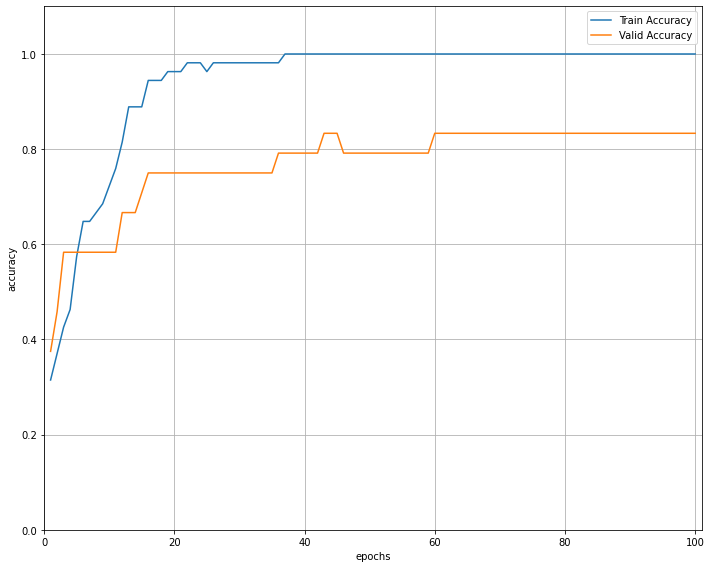

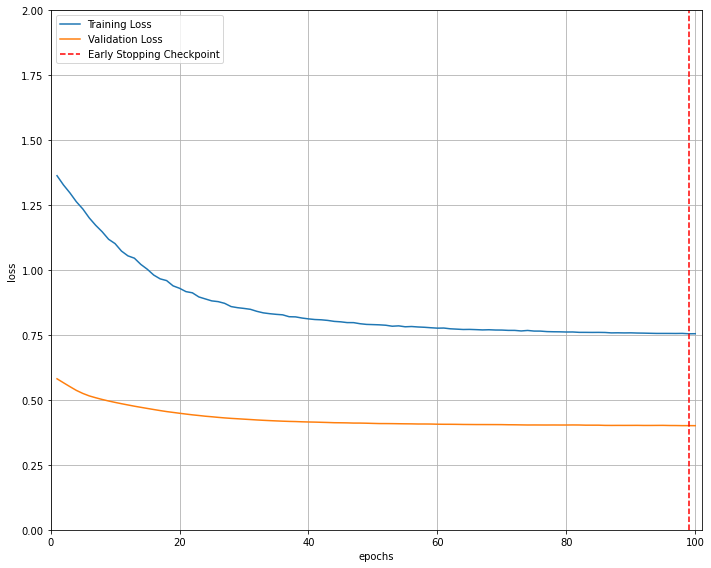

Confusion Matrix Without Normalization


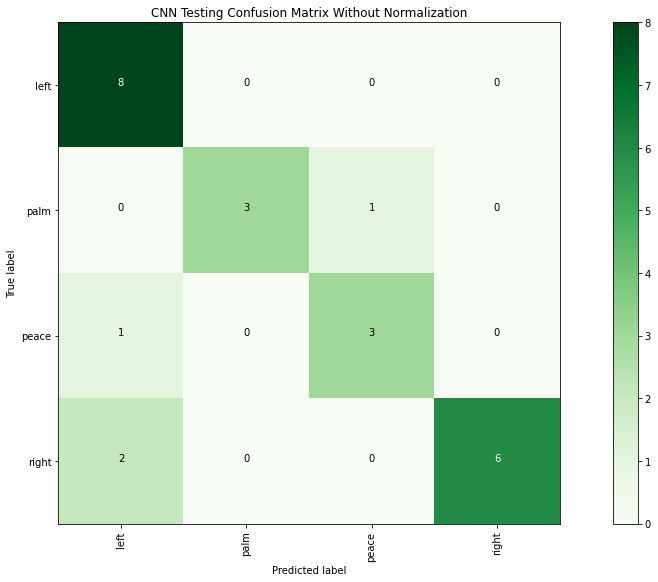

Normalized Confusion Matrix


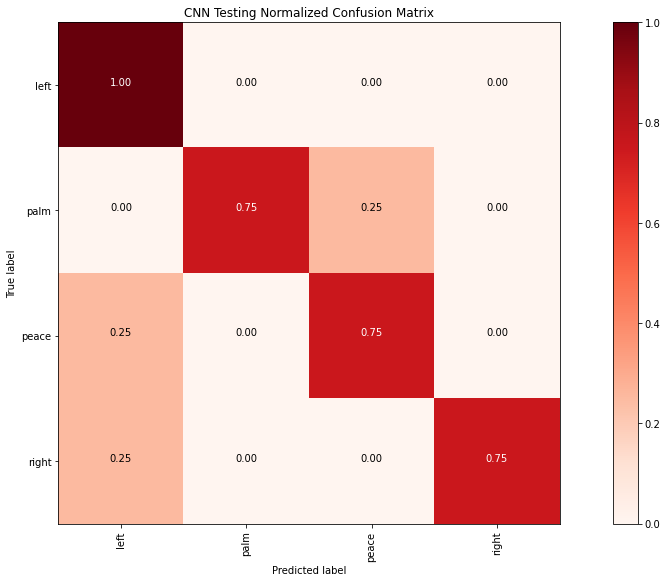

In [15]:
model = CNNModel1(in_channels=1, n_classes=n_classes)
model.load_state_dict(torch.load("CNNModel1.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["left", "palm", "peace", "right"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [16]:
accuracy_score(y_true, y_pred)

0.8333333333333334

In [17]:
class MyDataset2(Dataset):
    def __init__(self, data, is_train):
        self.data = data
        self.is_train = is_train

        self.image_transform_train = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.Resize(48), 
                transforms.CenterCrop(48),
                transforms.ToTensor(),
            ]
        )
        self.image_transform_test = transforms.Compose(
            [
                transforms.Grayscale(),
                transforms.Resize(48),
                transforms.CenterCrop(48), 
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image = Image.open(image_name).convert("RGB")
        if self.is_train:
            image_inp = self.image_transform_train(image)
        else:
            image_inp = self.image_transform_test(image)
        return image_inp, label

    def __len__(self):
        return len(self.data)

train, test = get_image_paths()
trainloader = DataLoader(MyDataset2(train, is_train=True), batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset2(test, is_train=False), batch_size=8, shuffle=True)

imgs, labels = next(iter(trainloader))
print(imgs.shape, labels.shape)
imgs, labels = next(iter(testloader))
print(imgs.shape, labels.shape)

torch.Size([8, 1, 48, 48]) torch.Size([8])
torch.Size([8, 1, 48, 48]) torch.Size([8])


In [18]:
class CNNModel2(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(CNNModel2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(800, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = CNNModel2(in_channels=1, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [19]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset2(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset2(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = CNNModel2(in_channels=1, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="CNNModel2.pth")

100%|██████████| 3/3 [00:00<00:00, 10.99it/s]


epoch=0 train loss=1.330451 test loss=0.589782 train accuracy=0.537 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00, 11.44it/s]


epoch=1 train loss=1.295163 test loss=0.582558 train accuracy=0.611 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00, 10.94it/s]


epoch=2 train loss=1.255836 test loss=0.569487 train accuracy=0.704 test accuracy=0.417


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


epoch=3 train loss=1.219874 test loss=0.550498 train accuracy=0.704 test accuracy=0.625


100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


epoch=4 train loss=1.183762 test loss=0.526875 train accuracy=0.704 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 11.48it/s]


epoch=5 train loss=1.153177 test loss=0.503031 train accuracy=0.704 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


epoch=6 train loss=1.128159 test loss=0.483067 train accuracy=0.722 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


epoch=7 train loss=1.108409 test loss=0.465882 train accuracy=0.704 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


epoch=8 train loss=1.085232 test loss=0.453210 train accuracy=0.741 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.73it/s]


epoch=9 train loss=1.079461 test loss=0.444033 train accuracy=0.759 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 11.07it/s]


epoch=10 train loss=1.046374 test loss=0.435958 train accuracy=0.759 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 11.25it/s]


epoch=11 train loss=1.029505 test loss=0.428243 train accuracy=0.759 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 11.08it/s]


epoch=12 train loss=1.015632 test loss=0.423718 train accuracy=0.796 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.98it/s]


epoch=13 train loss=1.013999 test loss=0.418528 train accuracy=0.778 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.97it/s]


epoch=14 train loss=0.990120 test loss=0.414492 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 11.29it/s]


epoch=15 train loss=0.977855 test loss=0.410015 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 11.41it/s]


epoch=16 train loss=0.963006 test loss=0.405288 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


epoch=17 train loss=0.957723 test loss=0.400335 train accuracy=0.907 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


epoch=18 train loss=0.937069 test loss=0.395181 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 11.09it/s]


epoch=19 train loss=0.920319 test loss=0.390475 train accuracy=0.926 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


epoch=20 train loss=0.908614 test loss=0.384659 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=21 train loss=0.892680 test loss=0.379993 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.16it/s]


epoch=22 train loss=0.879620 test loss=0.375480 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


epoch=23 train loss=0.865098 test loss=0.372234 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.06it/s]


epoch=24 train loss=0.856796 test loss=0.369277 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


epoch=25 train loss=0.845896 test loss=0.366611 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.18it/s]


epoch=26 train loss=0.841236 test loss=0.363734 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=27 train loss=0.836203 test loss=0.362212 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=28 train loss=0.826700 test loss=0.360000 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.30it/s]


epoch=29 train loss=0.821903 test loss=0.357952 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


epoch=30 train loss=0.815868 test loss=0.356271 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.90it/s]


epoch=31 train loss=0.814311 test loss=0.353828 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


epoch=32 train loss=0.807410 test loss=0.352490 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.04it/s]


epoch=33 train loss=0.802227 test loss=0.352016 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


epoch=34 train loss=0.802311 test loss=0.351057 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.96it/s]


epoch=35 train loss=0.795419 test loss=0.349809 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


epoch=36 train loss=0.793906 test loss=0.348667 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.40it/s]


epoch=37 train loss=0.789036 test loss=0.347962 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=38 train loss=0.790222 test loss=0.347527 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


epoch=39 train loss=0.783834 test loss=0.346819 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


epoch=40 train loss=0.782931 test loss=0.346241 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.28it/s]


epoch=41 train loss=0.785109 test loss=0.345593 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.91it/s]


epoch=42 train loss=0.783021 test loss=0.345153 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.37it/s]


epoch=43 train loss=0.777648 test loss=0.344110 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.22it/s]


epoch=44 train loss=0.776060 test loss=0.343209 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


epoch=45 train loss=0.774519 test loss=0.342520 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.13it/s]


epoch=46 train loss=0.776868 test loss=0.342200 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


epoch=47 train loss=0.774682 test loss=0.342044 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


epoch=48 train loss=0.773292 test loss=0.341577 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.75it/s]


epoch=49 train loss=0.772509 test loss=0.340642 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.41it/s]


epoch=50 train loss=0.768880 test loss=0.340589 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.73it/s]


epoch=51 train loss=0.768505 test loss=0.339995 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.22it/s]


epoch=52 train loss=0.767647 test loss=0.339366 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


epoch=53 train loss=0.768548 test loss=0.339510 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.87it/s]


epoch=54 train loss=0.765455 test loss=0.338998 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


epoch=55 train loss=0.767322 test loss=0.338496 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.00it/s]


epoch=56 train loss=0.764336 test loss=0.338777 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.01it/s]


epoch=57 train loss=0.764493 test loss=0.338314 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=58 train loss=0.763642 test loss=0.338001 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.16it/s]


epoch=59 train loss=0.761678 test loss=0.337973 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.59it/s]


epoch=60 train loss=0.763451 test loss=0.337991 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=61 train loss=0.761684 test loss=0.338022 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


epoch=62 train loss=0.760522 test loss=0.337447 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


epoch=63 train loss=0.761296 test loss=0.337252 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


epoch=64 train loss=0.760626 test loss=0.337146 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.08it/s]


epoch=65 train loss=0.760678 test loss=0.336645 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.45it/s]


epoch=66 train loss=0.758594 test loss=0.336891 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=67 train loss=0.759848 test loss=0.336904 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]


epoch=68 train loss=0.758291 test loss=0.336689 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.13it/s]


epoch=69 train loss=0.757726 test loss=0.336630 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.04it/s]


epoch=70 train loss=0.757966 test loss=0.336292 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=71 train loss=0.756438 test loss=0.335923 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.10it/s]


epoch=72 train loss=0.756043 test loss=0.335976 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


epoch=73 train loss=0.755800 test loss=0.336075 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


epoch=74 train loss=0.754648 test loss=0.335654 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.08it/s]


epoch=75 train loss=0.755287 test loss=0.335591 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


epoch=76 train loss=0.756247 test loss=0.335672 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


epoch=77 train loss=0.754583 test loss=0.335608 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.15it/s]


epoch=78 train loss=0.754637 test loss=0.335429 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.31it/s]


epoch=79 train loss=0.754957 test loss=0.334968 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.88it/s]


epoch=80 train loss=0.754364 test loss=0.334889 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


epoch=81 train loss=0.752798 test loss=0.335087 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.85it/s]


epoch=82 train loss=0.753442 test loss=0.335088 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.40it/s]


epoch=83 train loss=0.754337 test loss=0.335168 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.18it/s]


epoch=84 train loss=0.752920 test loss=0.335036 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


epoch=85 train loss=0.752982 test loss=0.334973 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.87it/s]


epoch=86 train loss=0.752551 test loss=0.334986 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.52it/s]


epoch=87 train loss=0.752161 test loss=0.334651 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=88 train loss=0.752305 test loss=0.334609 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.84it/s]


epoch=89 train loss=0.752267 test loss=0.334611 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=90 train loss=0.751612 test loss=0.334291 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


epoch=91 train loss=0.752011 test loss=0.334370 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


epoch=92 train loss=0.752394 test loss=0.334286 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=93 train loss=0.751261 test loss=0.334440 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=94 train loss=0.751378 test loss=0.334395 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


epoch=95 train loss=0.750910 test loss=0.334383 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.01it/s]


epoch=96 train loss=0.751119 test loss=0.334382 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=97 train loss=0.750690 test loss=0.334289 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


epoch=98 train loss=0.750378 test loss=0.334179 train accuracy=1.000 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.66it/s]

epoch=99 train loss=0.750247 test loss=0.334000 train accuracy=1.000 test accuracy=0.958


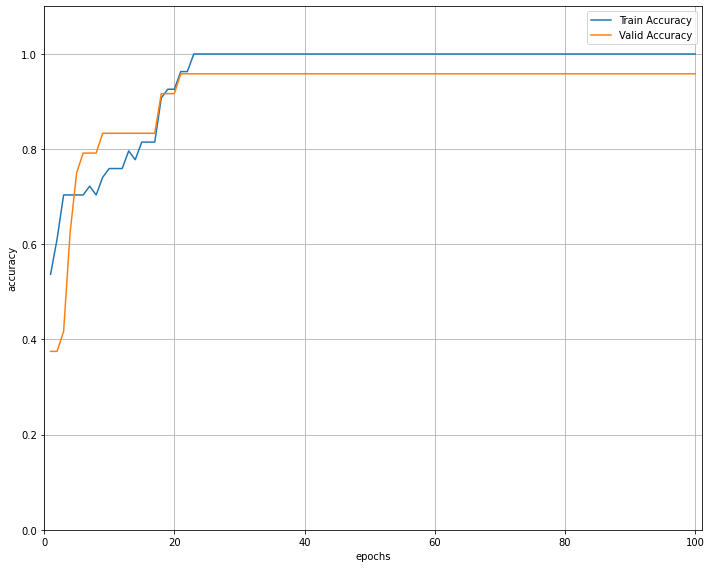

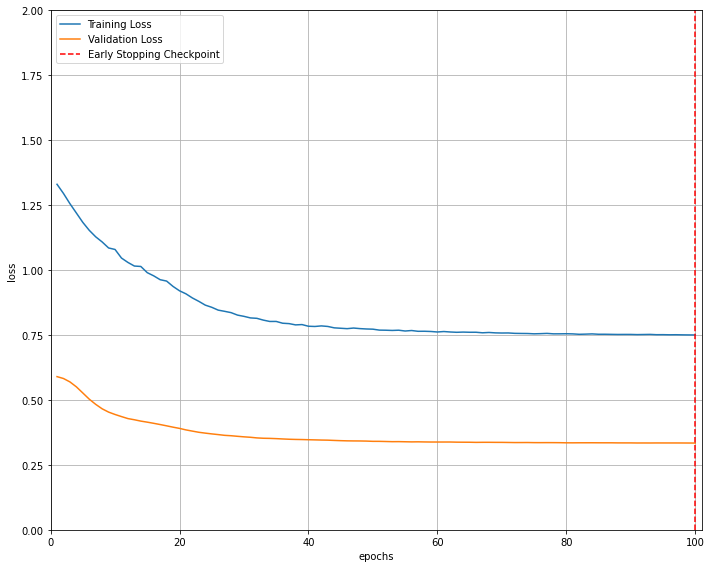

Confusion Matrix Without Normalization


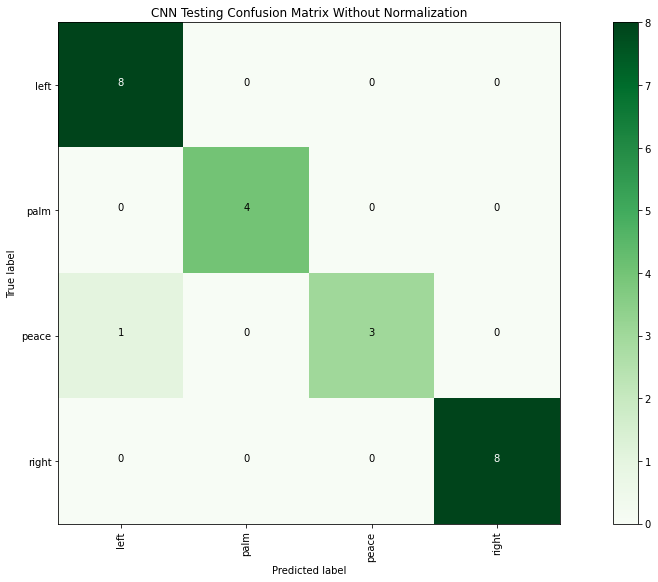

Normalized Confusion Matrix


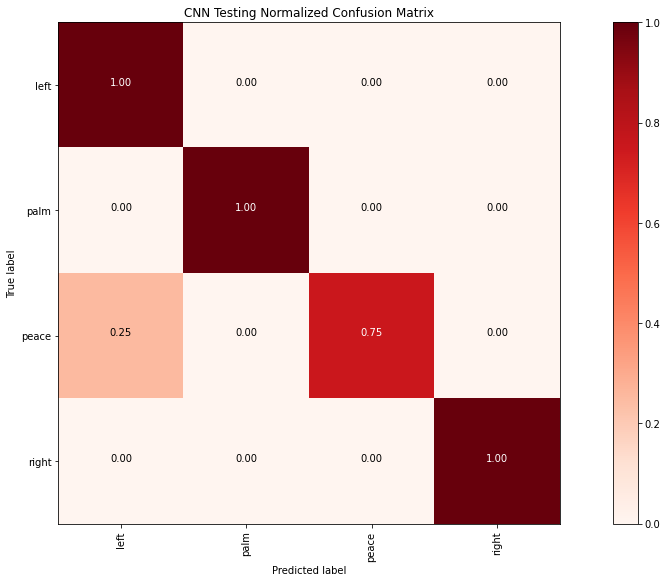

In [20]:
model = CNNModel2(in_channels=1, n_classes=n_classes)
model.load_state_dict(torch.load("CNNModel2.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["left", "palm", "peace", "right"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [21]:
accuracy_score(y_true, y_pred)

0.9583333333333334

In [22]:
class CNNModel3(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(128, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = CNNModel3(in_channels=1, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [23]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset2(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset2(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = CNNModel3(in_channels=1, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="CNNModel3.pth")

100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


epoch=0 train loss=1.435713 test loss=0.594315 train accuracy=0.259 test accuracy=0.167


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


epoch=1 train loss=1.418367 test loss=0.593262 train accuracy=0.278 test accuracy=0.333


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


epoch=2 train loss=1.404749 test loss=0.592708 train accuracy=0.278 test accuracy=0.167


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


epoch=3 train loss=1.393123 test loss=0.592535 train accuracy=0.315 test accuracy=0.125


100%|██████████| 3/3 [00:00<00:00, 10.35it/s]


epoch=4 train loss=1.383064 test loss=0.592545 train accuracy=0.315 test accuracy=0.167


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


epoch=5 train loss=1.367643 test loss=0.591482 train accuracy=0.370 test accuracy=0.250


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


epoch=6 train loss=1.363365 test loss=0.586700 train accuracy=0.370 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00, 10.10it/s]


epoch=7 train loss=1.346782 test loss=0.579878 train accuracy=0.370 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=8 train loss=1.335924 test loss=0.571674 train accuracy=0.407 test accuracy=0.417


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=9 train loss=1.320310 test loss=0.562869 train accuracy=0.426 test accuracy=0.500


100%|██████████| 3/3 [00:00<00:00, 10.50it/s]


epoch=10 train loss=1.309887 test loss=0.554300 train accuracy=0.444 test accuracy=0.542


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


epoch=11 train loss=1.301784 test loss=0.547047 train accuracy=0.463 test accuracy=0.625


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


epoch=12 train loss=1.291020 test loss=0.541125 train accuracy=0.481 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


epoch=13 train loss=1.275199 test loss=0.536313 train accuracy=0.519 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


epoch=14 train loss=1.269399 test loss=0.531648 train accuracy=0.500 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


epoch=15 train loss=1.255852 test loss=0.527400 train accuracy=0.556 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.96it/s]


epoch=16 train loss=1.246213 test loss=0.524465 train accuracy=0.556 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=17 train loss=1.234138 test loss=0.520410 train accuracy=0.630 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=18 train loss=1.220054 test loss=0.516875 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=19 train loss=1.210108 test loss=0.513821 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 11.05it/s]


epoch=20 train loss=1.198547 test loss=0.510763 train accuracy=0.667 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=21 train loss=1.199062 test loss=0.507125 train accuracy=0.704 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


epoch=22 train loss=1.185764 test loss=0.504074 train accuracy=0.685 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.00it/s]


epoch=23 train loss=1.176511 test loss=0.502133 train accuracy=0.667 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=24 train loss=1.164918 test loss=0.499267 train accuracy=0.685 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=25 train loss=1.158753 test loss=0.495661 train accuracy=0.667 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


epoch=26 train loss=1.154868 test loss=0.493775 train accuracy=0.704 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.14it/s]


epoch=27 train loss=1.147576 test loss=0.491815 train accuracy=0.722 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.68it/s]


epoch=28 train loss=1.143115 test loss=0.489011 train accuracy=0.704 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


epoch=29 train loss=1.130180 test loss=0.487025 train accuracy=0.704 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


epoch=30 train loss=1.118771 test loss=0.485334 train accuracy=0.722 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


epoch=31 train loss=1.117394 test loss=0.483345 train accuracy=0.704 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.78it/s]


epoch=32 train loss=1.108540 test loss=0.480650 train accuracy=0.722 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


epoch=33 train loss=1.098250 test loss=0.478528 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


epoch=34 train loss=1.108217 test loss=0.476664 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.12it/s]


epoch=35 train loss=1.097930 test loss=0.475365 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


epoch=36 train loss=1.091725 test loss=0.473737 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.75it/s]


epoch=37 train loss=1.083898 test loss=0.471646 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.42it/s]


epoch=38 train loss=1.087030 test loss=0.470328 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.42it/s]


epoch=39 train loss=1.075796 test loss=0.468137 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.79it/s]


epoch=40 train loss=1.079449 test loss=0.466773 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


epoch=41 train loss=1.068665 test loss=0.466269 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.81it/s]


epoch=42 train loss=1.065004 test loss=0.463954 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


epoch=43 train loss=1.058964 test loss=0.461973 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.85it/s]


epoch=44 train loss=1.058291 test loss=0.459952 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


epoch=45 train loss=1.051601 test loss=0.458486 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


epoch=46 train loss=1.042175 test loss=0.457339 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.41it/s]


epoch=47 train loss=1.036049 test loss=0.455417 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.97it/s]


epoch=48 train loss=1.040840 test loss=0.454422 train accuracy=0.741 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


epoch=49 train loss=1.034293 test loss=0.453199 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.57it/s]


epoch=50 train loss=1.033512 test loss=0.451920 train accuracy=0.741 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.20it/s]


epoch=51 train loss=1.032466 test loss=0.449988 train accuracy=0.741 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


epoch=52 train loss=1.020446 test loss=0.448689 train accuracy=0.759 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.95it/s]


epoch=53 train loss=1.022479 test loss=0.447066 train accuracy=0.759 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.96it/s]


epoch=54 train loss=1.028449 test loss=0.445749 train accuracy=0.759 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


epoch=55 train loss=1.025943 test loss=0.443448 train accuracy=0.759 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


epoch=56 train loss=1.012619 test loss=0.441718 train accuracy=0.778 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 10.87it/s]


epoch=57 train loss=1.014201 test loss=0.439788 train accuracy=0.741 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


epoch=58 train loss=1.001166 test loss=0.438447 train accuracy=0.778 test accuracy=0.792


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


epoch=59 train loss=0.999043 test loss=0.436729 train accuracy=0.778 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.73it/s]


epoch=60 train loss=0.992787 test loss=0.435098 train accuracy=0.796 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.55it/s]


epoch=61 train loss=0.993177 test loss=0.433651 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


epoch=62 train loss=0.988571 test loss=0.431376 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


epoch=63 train loss=0.974757 test loss=0.428210 train accuracy=0.815 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.97it/s]


epoch=64 train loss=0.980180 test loss=0.427215 train accuracy=0.852 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=65 train loss=0.967806 test loss=0.425715 train accuracy=0.815 test accuracy=0.875


100%|██████████| 3/3 [00:00<00:00, 11.04it/s]


epoch=66 train loss=0.972637 test loss=0.423096 train accuracy=0.833 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


epoch=67 train loss=0.955637 test loss=0.420765 train accuracy=0.870 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


epoch=68 train loss=0.960705 test loss=0.420148 train accuracy=0.870 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.41it/s]


epoch=69 train loss=0.953040 test loss=0.418500 train accuracy=0.889 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


epoch=70 train loss=0.944365 test loss=0.416398 train accuracy=0.889 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=71 train loss=0.939533 test loss=0.413664 train accuracy=0.981 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.85it/s]


epoch=72 train loss=0.938829 test loss=0.411964 train accuracy=0.944 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.89it/s]


epoch=73 train loss=0.932776 test loss=0.410730 train accuracy=0.944 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


epoch=74 train loss=0.929134 test loss=0.409712 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


epoch=75 train loss=0.921351 test loss=0.407261 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00,  6.66it/s]


epoch=76 train loss=0.922822 test loss=0.403944 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


epoch=77 train loss=0.926283 test loss=0.402727 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=78 train loss=0.912660 test loss=0.401737 train accuracy=0.981 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


epoch=79 train loss=0.907423 test loss=0.401529 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.79it/s]


epoch=80 train loss=0.896686 test loss=0.399195 train accuracy=0.981 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=81 train loss=0.896222 test loss=0.396445 train accuracy=0.963 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.31it/s]


epoch=82 train loss=0.899363 test loss=0.394189 train accuracy=0.944 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=83 train loss=0.886251 test loss=0.393499 train accuracy=0.963 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


epoch=84 train loss=0.887121 test loss=0.391672 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.74it/s]


epoch=85 train loss=0.882600 test loss=0.390768 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00,  9.95it/s]


epoch=86 train loss=0.879099 test loss=0.389701 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]


epoch=87 train loss=0.870850 test loss=0.388660 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


epoch=88 train loss=0.869249 test loss=0.385876 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


epoch=89 train loss=0.868988 test loss=0.385025 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


epoch=90 train loss=0.864896 test loss=0.382938 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.01it/s]


epoch=91 train loss=0.857781 test loss=0.381953 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 11.17it/s]


epoch=92 train loss=0.863860 test loss=0.380363 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


epoch=93 train loss=0.855716 test loss=0.379921 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.28it/s]


epoch=94 train loss=0.853224 test loss=0.379197 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


epoch=95 train loss=0.847162 test loss=0.377880 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=96 train loss=0.844441 test loss=0.377126 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.62it/s]


epoch=97 train loss=0.846435 test loss=0.375840 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


epoch=98 train loss=0.839337 test loss=0.373873 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]

epoch=99 train loss=0.837762 test loss=0.372684 train accuracy=1.000 test accuracy=1.000


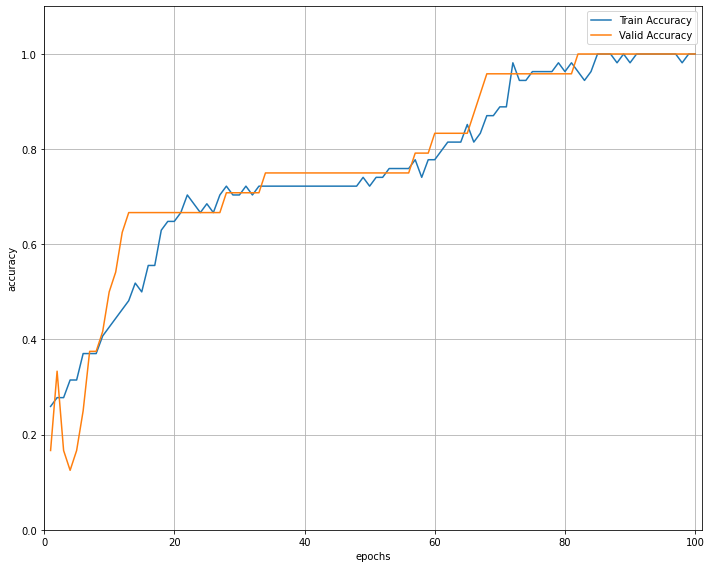

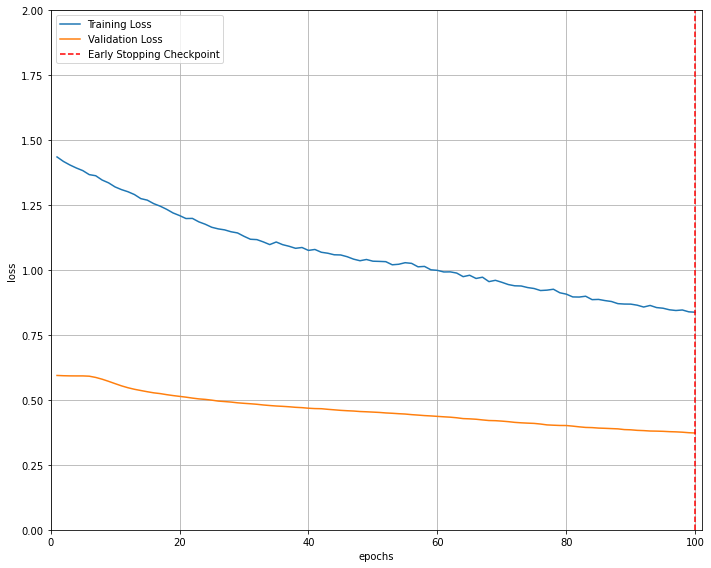

Confusion Matrix Without Normalization


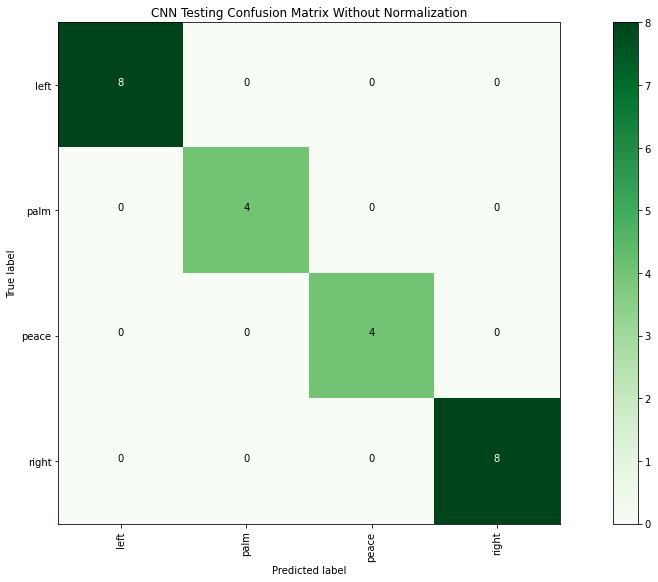

Normalized Confusion Matrix


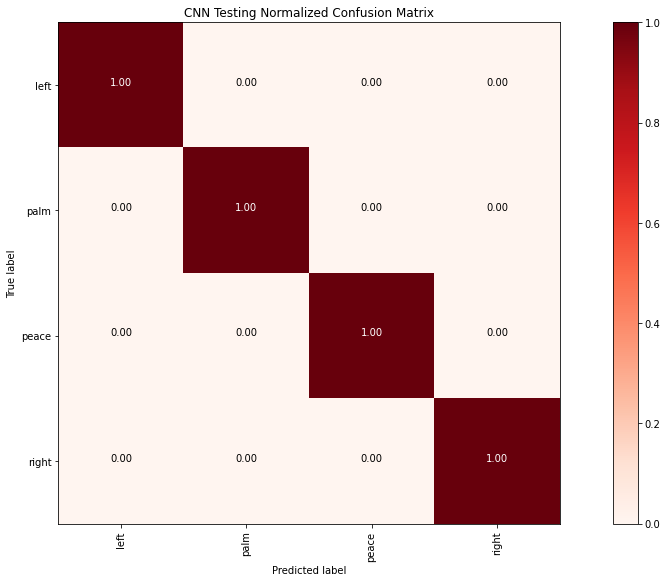

In [24]:
model = CNNModel3(in_channels=1, n_classes=n_classes)
model.load_state_dict(torch.load("CNNModel3.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["left", "palm", "peace", "right"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [25]:
accuracy_score(y_true, y_pred)

1.0

In [26]:
class MyDataset3(Dataset):
    def __init__(self, data, is_train):
        self.data = data
        self.is_train = is_train

        self.image_transform_train = transforms.Compose(
            [
                transforms.Resize(48), 
                transforms.CenterCrop(48),
                transforms.ToTensor(),
            ]
        )
        self.image_transform_test = transforms.Compose(
            [
                transforms.Resize(48),
                transforms.CenterCrop(48), 
                transforms.ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image = Image.open(image_name).convert("RGB")
        if self.is_train:
            image_inp = self.image_transform_train(image)
        else:
            image_inp = self.image_transform_test(image)
        return image_inp, label

    def __len__(self):
        return len(self.data)

train, test = get_image_paths()
trainloader = DataLoader(MyDataset3(train, is_train=True), batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset3(test, is_train=False), batch_size=8, shuffle=True)

imgs, labels = next(iter(trainloader))
print(imgs.shape, labels.shape)
imgs, labels = next(iter(testloader))
print(imgs.shape, labels.shape)

torch.Size([8, 3, 48, 48]) torch.Size([8])
torch.Size([8, 3, 48, 48]) torch.Size([8])


In [27]:
class CNNModel4(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(CNNModel4, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 4, 3),
            nn.BatchNorm2d(4),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        self.flat = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(800, n_classes),
        )
        self.sm = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool2(x)

        x = self.flat(x)
        x = self.fc1(x)
        out = self.sm(x)
        return out

n_classes = 4
model = CNNModel4(in_channels=3, n_classes=n_classes)
batch_image, batch_label = next(iter(trainloader))
batch_output = model(batch_image)
batch_output.shape, batch_label.shape

(torch.Size([8, 4]), torch.Size([8]))

In [28]:
train, test = get_image_paths()
trainloader = DataLoader(MyDataset3(train, is_train=True), num_workers=2, batch_size=8, shuffle=True)
testloader = DataLoader(MyDataset3(test, is_train=False), num_workers=2, batch_size=8, shuffle=True)

n_classes = 4
model = CNNModel4(in_channels=3, n_classes=n_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses, train_accs, test_accs = trainer(model, optimizer, criterion, trainloader, testloader, epochs=100, model_name="CNNModel4.pth")

100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


epoch=0 train loss=1.401993 test loss=0.589351 train accuracy=0.148 test accuracy=0.375


100%|██████████| 3/3 [00:00<00:00, 10.85it/s]


epoch=1 train loss=1.356636 test loss=0.586742 train accuracy=0.426 test accuracy=0.458


100%|██████████| 3/3 [00:00<00:00, 10.22it/s]


epoch=2 train loss=1.320048 test loss=0.579676 train accuracy=0.556 test accuracy=0.542


100%|██████████| 3/3 [00:00<00:00, 10.86it/s]


epoch=3 train loss=1.284241 test loss=0.567104 train accuracy=0.630 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.93it/s]


epoch=4 train loss=1.241836 test loss=0.548142 train accuracy=0.630 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.38it/s]


epoch=5 train loss=1.212308 test loss=0.525809 train accuracy=0.630 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


epoch=6 train loss=1.187131 test loss=0.504383 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


epoch=7 train loss=1.153924 test loss=0.487130 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


epoch=8 train loss=1.128157 test loss=0.473939 train accuracy=0.648 test accuracy=0.667


100%|██████████| 3/3 [00:00<00:00, 10.64it/s]


epoch=9 train loss=1.113459 test loss=0.462602 train accuracy=0.648 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.30it/s]


epoch=10 train loss=1.098617 test loss=0.453755 train accuracy=0.667 test accuracy=0.708


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=11 train loss=1.068883 test loss=0.444710 train accuracy=0.722 test accuracy=0.750


100%|██████████| 3/3 [00:00<00:00,  9.72it/s]


epoch=12 train loss=1.046813 test loss=0.436161 train accuracy=0.778 test accuracy=0.833


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


epoch=13 train loss=1.029282 test loss=0.427135 train accuracy=0.796 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 10.58it/s]


epoch=14 train loss=1.011390 test loss=0.417208 train accuracy=0.870 test accuracy=0.917


100%|██████████| 3/3 [00:00<00:00, 10.39it/s]


epoch=15 train loss=0.986739 test loss=0.408504 train accuracy=0.907 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


epoch=16 train loss=0.970189 test loss=0.400332 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.66it/s]


epoch=17 train loss=0.950281 test loss=0.393571 train accuracy=0.963 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


epoch=18 train loss=0.934307 test loss=0.386837 train accuracy=0.981 test accuracy=0.958


100%|██████████| 3/3 [00:00<00:00, 11.01it/s]


epoch=19 train loss=0.922108 test loss=0.380789 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.72it/s]


epoch=20 train loss=0.904796 test loss=0.376202 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.71it/s]


epoch=21 train loss=0.895123 test loss=0.370796 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


epoch=22 train loss=0.884214 test loss=0.367385 train accuracy=0.981 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=23 train loss=0.873941 test loss=0.363486 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.76it/s]


epoch=24 train loss=0.862752 test loss=0.360288 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=25 train loss=0.850415 test loss=0.357315 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.18it/s]


epoch=26 train loss=0.846444 test loss=0.355296 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=27 train loss=0.843452 test loss=0.352932 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.60it/s]


epoch=28 train loss=0.833877 test loss=0.350287 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.36it/s]


epoch=29 train loss=0.826039 test loss=0.349239 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


epoch=30 train loss=0.824593 test loss=0.347944 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


epoch=31 train loss=0.816019 test loss=0.346165 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


epoch=32 train loss=0.812057 test loss=0.345202 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.99it/s]


epoch=33 train loss=0.811562 test loss=0.343523 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.35it/s]


epoch=34 train loss=0.805537 test loss=0.342644 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 11.04it/s]


epoch=35 train loss=0.803300 test loss=0.341382 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.77it/s]


epoch=36 train loss=0.795899 test loss=0.340351 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


epoch=37 train loss=0.793192 test loss=0.339443 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.25it/s]


epoch=38 train loss=0.790958 test loss=0.338509 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=39 train loss=0.789581 test loss=0.337384 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 11.02it/s]


epoch=40 train loss=0.787421 test loss=0.337243 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


epoch=41 train loss=0.783638 test loss=0.336680 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


epoch=42 train loss=0.780988 test loss=0.336303 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.07it/s]


epoch=43 train loss=0.782132 test loss=0.335959 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


epoch=44 train loss=0.783919 test loss=0.335189 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.95it/s]


epoch=45 train loss=0.777837 test loss=0.334304 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


epoch=46 train loss=0.775916 test loss=0.334132 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.56it/s]


epoch=47 train loss=0.772732 test loss=0.333504 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


epoch=48 train loss=0.773289 test loss=0.333248 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.88it/s]


epoch=49 train loss=0.771293 test loss=0.333012 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.45it/s]


epoch=50 train loss=0.769910 test loss=0.332514 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.79it/s]


epoch=51 train loss=0.769525 test loss=0.331791 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.17it/s]


epoch=52 train loss=0.770929 test loss=0.331095 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


epoch=53 train loss=0.768979 test loss=0.331191 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.15it/s]


epoch=54 train loss=0.767392 test loss=0.330664 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.29it/s]


epoch=55 train loss=0.765365 test loss=0.330752 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.45it/s]


epoch=56 train loss=0.767559 test loss=0.330652 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 11.07it/s]


epoch=57 train loss=0.766054 test loss=0.330462 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.32it/s]


epoch=58 train loss=0.763028 test loss=0.330259 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.40it/s]


epoch=59 train loss=0.762494 test loss=0.330155 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.13it/s]


epoch=60 train loss=0.762685 test loss=0.329644 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.82it/s]


epoch=61 train loss=0.762467 test loss=0.329123 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.21it/s]


epoch=62 train loss=0.760782 test loss=0.329017 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


epoch=63 train loss=0.759950 test loss=0.329237 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.55it/s]


epoch=64 train loss=0.760762 test loss=0.329224 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.87it/s]


epoch=65 train loss=0.759960 test loss=0.328976 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00,  9.77it/s]


epoch=66 train loss=0.758929 test loss=0.328804 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.99it/s]


epoch=67 train loss=0.758654 test loss=0.328653 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.67it/s]


epoch=68 train loss=0.757953 test loss=0.328537 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.26it/s]


epoch=69 train loss=0.757858 test loss=0.328218 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.48it/s]


epoch=70 train loss=0.758990 test loss=0.328075 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.69it/s]


epoch=71 train loss=0.756514 test loss=0.328005 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.84it/s]


epoch=72 train loss=0.756900 test loss=0.327658 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.44it/s]


epoch=73 train loss=0.755362 test loss=0.327773 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.16it/s]


epoch=74 train loss=0.755509 test loss=0.327674 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.94it/s]


epoch=75 train loss=0.755174 test loss=0.327509 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.65it/s]


epoch=76 train loss=0.755552 test loss=0.327372 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.80it/s]


epoch=77 train loss=0.755843 test loss=0.327198 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.04it/s]


epoch=78 train loss=0.754357 test loss=0.326958 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.37it/s]


epoch=79 train loss=0.754966 test loss=0.326811 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.88it/s]


epoch=80 train loss=0.754950 test loss=0.326857 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


epoch=81 train loss=0.754127 test loss=0.327041 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.51it/s]


epoch=82 train loss=0.753793 test loss=0.326982 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.63it/s]


epoch=83 train loss=0.753632 test loss=0.326742 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00,  9.98it/s]


epoch=84 train loss=0.753502 test loss=0.326615 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.27it/s]


epoch=85 train loss=0.753568 test loss=0.326318 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


epoch=86 train loss=0.752660 test loss=0.326116 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


epoch=87 train loss=0.752624 test loss=0.326268 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.49it/s]


epoch=88 train loss=0.752283 test loss=0.326226 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.24it/s]


epoch=89 train loss=0.753312 test loss=0.326288 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.47it/s]


epoch=90 train loss=0.752329 test loss=0.326231 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.53it/s]


epoch=91 train loss=0.751693 test loss=0.325952 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.19it/s]


epoch=92 train loss=0.751920 test loss=0.325868 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


epoch=93 train loss=0.752335 test loss=0.325753 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.61it/s]


epoch=94 train loss=0.753128 test loss=0.325944 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.84it/s]


epoch=95 train loss=0.750731 test loss=0.325682 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.83it/s]


epoch=96 train loss=0.751000 test loss=0.325849 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.33it/s]


epoch=97 train loss=0.751031 test loss=0.325717 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.54it/s]


epoch=98 train loss=0.750577 test loss=0.325555 train accuracy=1.000 test accuracy=1.000


100%|██████████| 3/3 [00:00<00:00, 10.42it/s]

epoch=99 train loss=0.750508 test loss=0.325443 train accuracy=1.000 test accuracy=1.000


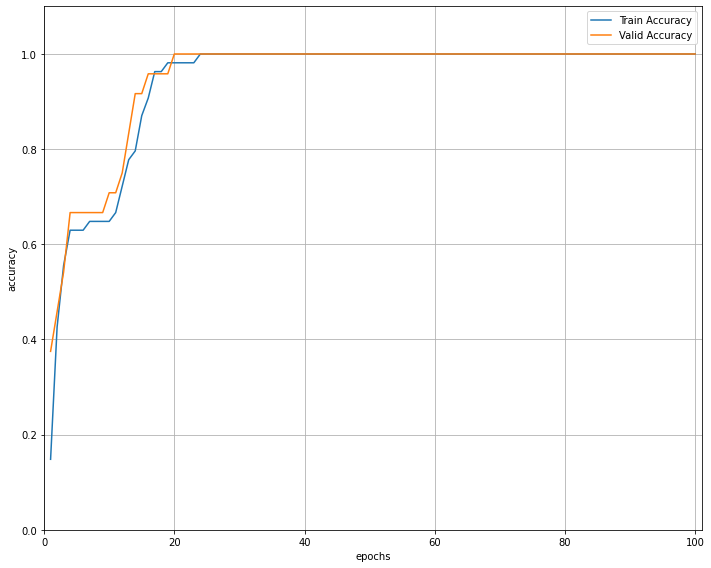

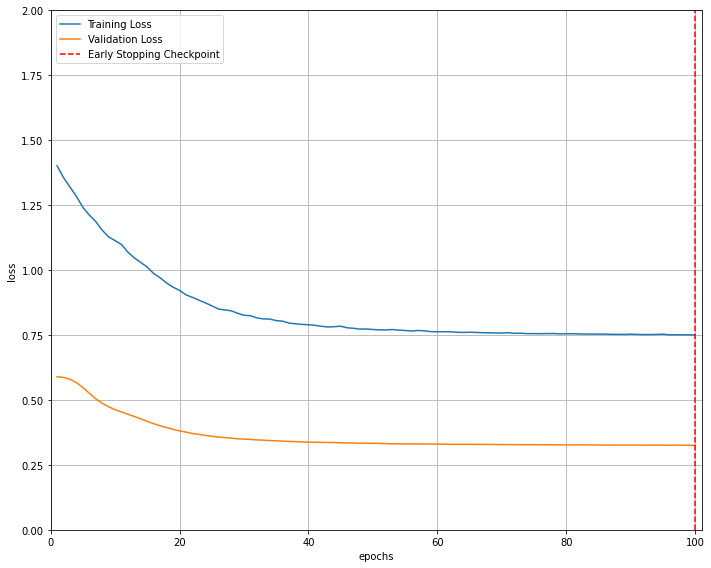

Confusion Matrix Without Normalization


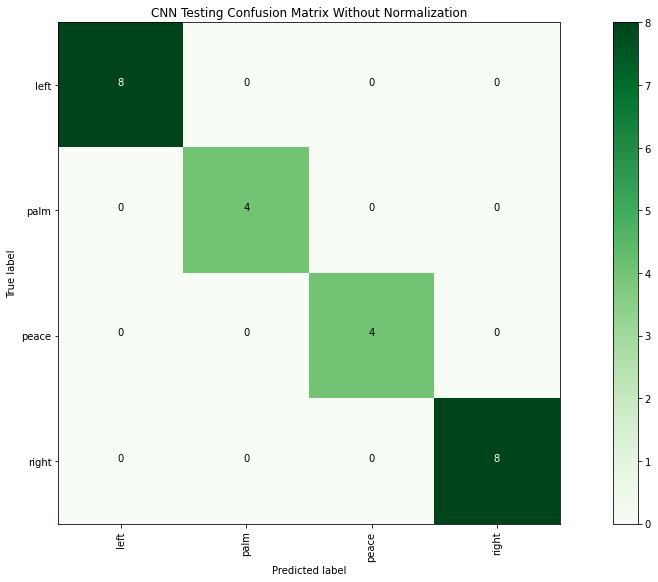

Normalized Confusion Matrix


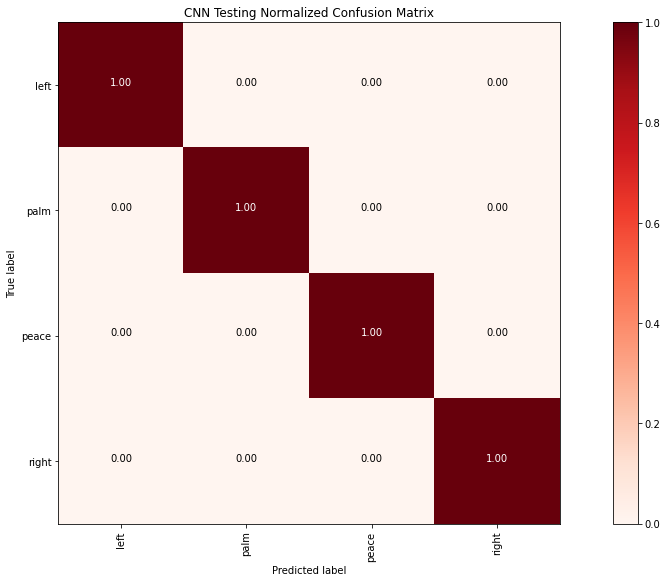

In [29]:
model = CNNModel4(in_channels=3, n_classes=n_classes)
model.load_state_dict(torch.load("CNNModel4.pth", map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))

activities = ["left", "palm", "peace", "right"]
plot_accuracy_per_epoch(train_accs, test_accs)
plot_avg_loss_per_epoch(train_losses, test_losses)
y_true, y_pred = tester(model, testloader)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='CNN Testing Normalized Confusion Matrix')

In [30]:
accuracy_score(y_true, y_pred)

1.0